#AllTissueJunctionAnalysis as a Notebook 

rMATS 3.2.5 was run on controlled access RNASeq files retrieved experiments stored in the Sequence Read Archive with controlled access managed by dbGaP.   The data were generated under the Gene Tissue Expression.

## rMATS RNASeq-MATS.py produces 10 different output types which get assembled into as type junction ID by sample ID matrices

### Alternative Splice Site Types are: (se, a3ss, a5ss, mxe, ri)

 This is input as ARGV1 into variable 'astype'

  * Skipped Exon events (se),
  * Alternative 3' splice site (a3ss),
  * Alternative 5' splice site (a5ss),
  * Mutually exclusive exon (mxe),
  * and retention intron (ri)

### There are two different kinds of junction counts

  * jc = junction counts - reads that cross the junction
  * jcec = junction counts plus reads on the target (such as included exon

### And the count type -- there are 5 types

  * inclusion levels (percent spliced in)
  * included junction counts (ijc)
  * skipped junction counts (sjc)
  * inclusion length (inclen)
  * skipped length (skiplen)

### function: fit_iso_tissue 

fit_iso_tissue expects the following input:

  * the tissue of interest (SMSTD) 
  * an ordered_merged_rmats -- which will be ordered to fit the count matrix
  * count matrix (inc or ijc & sjc merged)
  * splice type (a3ss, a5ss, mxe, ri or se)
  * junction_count type (jc or jcec)
  * count type (inc or the merged ijc,sjc)
  
### reordering to match annotations between count matrix and annotation matrix

Common problem is to match specifically the rows of an annotation matrix with the columns of a count matrix
`match` is the function that gives the re-ordering index required to accomplish this


## **NOTE**:

We assume that you have cloned the analysis repository and have `cd` into the parent directory. Before starting with the analysis make sure you have first completed the dependencies set up by following the instructions described in the **`dependencies/README.md`** document. All paths defined in this Notebook are relative to the parent directory (repository). Please close this Notebook and start again by following the above guidelines if you have not completed the aforementioned steps.

## rMATS-final-merged
the rmats-nf NextFlow was executed and the results released here:

## Loading dependencies

In [1]:
# temporary hack remove me when the dependencies are fixed
#
#install.packages("BiocManager")
#Sys.setenv(TAR = "/bin/tar")
#BiocManager::install(c('limma','edgeR', 'statmod'))
#install.packages(c('doParallel', 'doRNG', 'foreach', 'stringi', 'pheatmap'), repo = 'https://cran.r-project.org')
#devtools::install_github("ropensci/piggyback@87f71e8", upgrade="never")
#install.packages("runjags", repos = "https://cran.r-project.org")
#devtools::install_github("easystats/report")


In [2]:
library(limma)
library(piggyback)
library(multtest)
library(Biobase)
library(edgeR)
library(tibble)
install.packages('R.utils')
library(R.utils)

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Loading required package: Biobase
Welcome to Bio

## Modeling

This analysis uses edgeR.  From the documentation, it is important to note that normalization takes the form of correction factors that enter into the statistical model. Such correction factors are usually computed internally by edgeR functions, but it is also possible for a user to supply them. The correction factors may take the form of scaling factors for the library sizes, such as computed by calcNormFactors, which are then used to compute the effective library sizes. 

Alternatively, gene-specific correction factors can be entered into the glm functions of edgeR as offsets. In the latter case, the offset matrix will be assumed to account for all normalization issues, including sequencing depth and RNA composition.

Note that normalization in edgeR is model-based, and the original read counts are not themselves transformed. This means that users should not transform the read counts in any way before inputing them to edgeR. For example, users should not enter RPKM or FPKM val- ues to edgeR in place of read counts. Such quantities will prevent edgeR from correctly estimating the mean-variance relationship in the data, which is a crucial to the statistical strategies underlying edgeR. Similarly, users should not add artificial values to the counts before inputing them to edgeR.

edgeR is not designed to work with estimated expression levels, for example as might be output by Cufflinks. 
edgeR can work with expected counts as output by RSEM, but raw counts are still preferred. 

As instructed by the software, we are using the raw counts as provided by rMATS.  The raw counts we are using in the model are `ijc` and `sjc`, the sample specific raw read counts as they align to the junctions of the `included exon (ijc)` and the junctions of the `excluded or skipped exon (sjc)` respectively.


Be sure to set your GITHUB_TOKEN, prior to downloading files

One suggestion is change it to your token and then run it then immediately change it back to this:

Sys.setenv(GITHUB_TOKEN = "your-very-own-github-token")

In [3]:
# devtools::install_github("ropensci/piggyback@87f71e8", upgrade="never")
Sys.setenv(GITHUB_TOKEN = "your-very-own-github-token")

### Did you remember?
Did you remember to delete your private github token?  Now is a good time to do so, before you save your work and checkit in inadvertantly....

In [4]:
piggyback::pb_download(
    repo = "TheJacksonLaboratory/sbas", 
    file = "SraRunTable.noCram.noExome.noWGS.totalRNA.txt.gz",
    tag  = "GTExV8.v1.0", 
    dest = "../data/")

piggyback::pb_download(
    repo = "adeslatt/sbas_test", 
    file = "rmats_final.se.jc.ijc.txt.gz",
    tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
    dest = "../data/")

piggyback::pb_download(
    repo = "adeslatt/sbas_test", 
    file = "rmats_final.se.jc.sjc.txt.gz",
    tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
    dest = "../data/")

ijc.iso.counts.mem <- data.table::fread("../data/rmats_final.se.jc.ijc.txt.gz") 
sjc.iso.counts.mem <- data.table::fread("../data/rmats_final.se.jc.sjc.txt.gz") 
meta.data          <- data.table::fread("../data/SraRunTable.noCram.noExome.noWGS.totalRNA.txt.gz")

head(ijc.iso.counts.mem)
head(sjc.iso.counts.mem)
head(meta.data)

#dimensions before we make the changes.
dim(ijc.iso.counts.mem)
dim(sjc.iso.counts.mem)
dim(meta.data)

All files up-to-date already

All files up-to-date already

All files up-to-date already



ID,SRR1068788,SRR1068808,SRR1068832,SRR1068855,SRR1068880,SRR1068929,SRR1068953,SRR1068977,SRR1068999,⋯,SRR821573,SRR821581,SRR821602,SRR821626,SRR821653,SRR821690,SRR821715,SRR823967,SRR823991,SRR824015
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,26,247,103,620,494,145,145,139,697,⋯,151,32,62,48,963,25,196,76,72,61
3,1,0,1,0,0,0,1,1,2,⋯,2,1,0,1,3,0,1,0,0,0
4,0,1,1,2,0,0,1,0,2,⋯,0,0,0,0,1,0,0,0,0,0
5,3,0,2,3,6,1,1,1,5,⋯,3,2,0,1,6,0,2,0,0,0
6,2,1,2,5,6,1,1,0,5,⋯,1,1,0,0,4,0,1,0,0,0


ID,SRR1068788,SRR1068808,SRR1068832,SRR1068855,SRR1068880,SRR1068929,SRR1068953,SRR1068977,SRR1068999,⋯,SRR821573,SRR821581,SRR821602,SRR821626,SRR821653,SRR821690,SRR821715,SRR823967,SRR823991,SRR824015
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,2,0,1,3,6,1,0,0,3,⋯,1,1,0,0,3,0,1,0,0,0
2,0,0,0,1,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,1,⋯,0,0,0,0,2,0,1,0,0,0
5,0,5,3,8,4,0,3,0,3,⋯,9,3,1,2,3,0,1,0,1,0
6,11,119,36,284,207,60,63,43,295,⋯,52,13,14,9,338,8,63,25,20,18


Run,analyte_type,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,biospecimen_repository,biospecimen_repository_sample_id,body_site,⋯,data_type (run),product_part_number (exp),product_part_number (run),sample_barcode (exp),sample_barcode (run),is_technical_control,target_set (exp),primary_disease (exp),secondary_accessions (run),Alignment_Provider (run)
<chr>,<chr>,<chr>,<int>,<int64>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<lgl>,<chr>,<chr>,<lgl>
SRR2911715,RNA,RNA-Seq,150,3852895500,PRJNA244100,SAMN04216864,Cloud Testing,HG00103,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
SRR2911716,RNA,RNA-Seq,150,4885577400,PRJNA244100,SAMN04216866,Cloud Testing,HG00154,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
SRR2911718,RNA,RNA-Seq,150,2690545500,PRJNA244100,SAMN04216863,Cloud Testing,NA18910,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
SRR2911719,RNA,RNA-Seq,150,2699599350,PRJNA244100,SAMN04216865,Cloud Testing,NA19200,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
SRR2911720,RNA,RNA-Seq,152,4300467752,PRJNA244100,SAMN04216865,Cloud Testing,NA19200,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
SRR2911717,RNA,RNA-Seq,150,2666546700,PRJNA244100,SAMN04216863,Cloud Testing,NA18910,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA


[1] 42611  8674

[1] 42611  8674

[1] 9784   79

## Synchronize metadata samples with ijc sjc samples

Keep only the runs that are in the ijc count list (assuming ijc and sjc are the same).  As well, name the rows with the junction id column and then make the matrix just about the counts.

In [5]:
# the sample names are in the columns of both the ijc and the sjc matrices, these matrices have the identical column order)
keep.meta.data <- meta.data$Run %in% colnames(ijc.iso.counts.mem)
table(keep.meta.data)
reduced.meta.data <- meta.data[keep.meta.data==TRUE,]

# preserve junction id as rowname
rownames(ijc.iso.counts.mem) <- ijc.iso.counts.mem$ID
rownames(sjc.iso.counts.mem) <- sjc.iso.counts.mem$ID

# and remove the id to have a data matrix
ijc.iso.counts.mem  <- ijc.iso.counts.mem[,-1]
sjc.iso.counts.mem  <- sjc.iso.counts.mem[,-1]

keep.meta.data
FALSE  TRUE 
 1111  8673 

## Order ijc and sjc columns in the same order as the metadata Run order

Using tibble library, we can rearrange the columns as the column name.  

In [6]:
meta.data.run.names  <- as.character(reduced.meta.data$Run)
ijc.iso.counts.mem2  <- as_tibble(ijc.iso.counts.mem)
sjc.iso.counts.mem2  <- as_tibble(sjc.iso.counts.mem)

ijc.iso.counts.mem2  <- ijc.iso.counts.mem2[,c(meta.data.run.names)]
sjc.iso.counts.mem2  <- sjc.iso.counts.mem2[,c(meta.data.run.names)]

dim(ijc.iso.counts.mem2)
dim(sjc.iso.counts.mem2)
dim(reduced.meta.data)

[1] 42611  8673

[1] 42611  8673

[1] 8673   79

Remove samples that match '11IL0' from the ijc, sjc and metadata files using the logical grep, grepl

In [7]:
keep.meta.data <- (!grepl('11ILO',reduced.meta.data$"Sample Name"))
table(keep.meta.data)
ijc.iso.counts.mem2 <-ijc.iso.counts.mem2 [                    ,keep.meta.data==TRUE]
sjc.iso.counts.mem2 <-sjc.iso.counts.mem2 [                    ,keep.meta.data==TRUE]

reduced.meta.data   <-reduced.meta.data   [keep.meta.data==TRUE,                    ]
dim(ijc.iso.counts.mem2)
dim(sjc.iso.counts.mem2)

keep.meta.data
FALSE  TRUE 
   12  8661 

[1] 42611  8661

[1] 42611  8661

### and now for all tissues


### exploration of the details

For each sample, we have ijc and sjc count data and demo
For exon skipping events (SE), we have 42,611 non-zero junction IDs the (first dimension of the ijc and sjc cout table) for the skipped exon event for breast-Mammary Tissue, 191 individuals.  These are healthy individuals, and we are studying the impact of sex on the occurrence or non-occurance of specific alternative splicing events.   We explore the information we ahve about these junctions and create a construct, as_event, which accounts for the junction under exploration.

#### Exploring the ijc and sjc Count data 

We have two counts that are in many ways two sides of the same coin.  Both our the observational output and we wish to see how robust each are in their ability to separate out the samples to provide for us differentially expressed isoform events as measured by their counts.   Each junction is in a manner a specific marker to specific isoform events that may or may not be shared between the genders.   If there is significant results, then this is indicative of the separation achieved by isoform specific differentiation.   In our model we will use these in combination, it is important to see if they will yield the results we are looking for.

## Preparing the data further

### Keeping only tissues shared male female

We need to remove the tissues that are not shared by males and females, we do this by finding the intersection of the tissue lists.

In [103]:
tissue_list <- factor(reduced.meta.data$body_site)
length(tissue_list)

male_tissues_true   <- reduced.meta.data$sex == "male"
female_tissues_true <- reduced.meta.data$sex == "female"

sum(table(male_tissues_true))
sum(table(female_tissues_true))

male_tissue_list   <- factor(tissue_list[male_tissues_true   == TRUE])
female_tissue_list <- factor(tissue_list[female_tissues_true == TRUE])

male_female_tissue_list <- intersect(levels(male_tissue_list),levels(female_tissue_list))

keep = tissue_list %in% male_female_tissue_list

table(keep)

ijc_m_f         = ijc.iso.counts.mem2[          ,keep==TRUE]
sjc_m_f         = sjc.iso.counts.mem2[          ,keep==TRUE]
metadata_m_f    = reduced.meta.data  [keep==TRUE,          ]
tissue_list_m_f = tissue_list        [keep==TRUE]

dim(ijc_m_f)
dim(sjc_m_f)
dim(metadata_m_f)
length(tissue_list_m_f)
tissue_list_m_f <- factor(tissue_list_m_f)
levels(tissue_list_m_f)
length(levels(tissue_list_m_f))

[1] 8661

[1] 8661

[1] 8661

keep
FALSE  TRUE 
  673  7988 

[1] 42611  7988

[1] 42611  7988

[1] 7988   79

[1] 7988

[1] "Adipose - Subcutaneous"                   
 [2] "Adipose - Visceral (Omentum)"             
 [3] "Adrenal Gland"                            
 [4] "Artery - Aorta"                           
 [5] "Artery - Coronary"                        
 [6] "Artery - Tibial"                          
 [7] "Bladder"                                  
 [8] "Brain - Amygdala"                         
 [9] "Brain - Anterior cingulate cortex (BA24)" 
[10] "Brain - Caudate (basal ganglia)"          
[11] "Brain - Cerebellar Hemisphere"            
[12] "Brain - Cerebellum"                       
[13] "Brain - Cortex"                           
[14] "Brain - Frontal Cortex (BA9)"             
[15] "Brain - Hippocampus"                      
[16] "Brain - Hypothalamus"                     
[17] "Brain - Nucleus accumbens (basal ganglia)"
[18] "Brain - Putamen (basal ganglia)"          
[19] "Brain - Spinal cord (cervical c-1)"       
[20] "Brain - Substantia nigra"                 
[21] "Breast - Mammary Tissue"                  
[22] "Cells - Cultured fibroblasts"             
[23] "Cells - EBV-transformed lymphocytes"      
[24] "Colon - Sigmoid"                          
[25] "Colon - Transverse"                       
[26] "Esophagus - Gastroesophageal Junction"    
[27] "Esophagus - Mucosa"                       
[28] "Esophagus - Muscularis"                   
[29] "Heart - Atrial Appendage"                 
[30] "Heart - Left Ventricle"                   
[31] "Kidney - Cortex"                          
[32] "Liver"                                    
[33] "Lung"                                     
[34] "Minor Salivary Gland"                     
[35] "Muscle - Skeletal"                        
[36] "Nerve - Tibial"                           
[37] "Pancreas"                                 
[38] "Pituitary"                                
[39] "Skin - Not Sun Exposed (Suprapubic)"      
[40] "Skin - Sun Exposed (Lower leg)"           
[41] "Small Intestine - Terminal Ileum"         
[42] "Spleen"                                   
[43] "Stomach"                                  
[44] "Thyroid"                                  
[45] "Whole Blood"

[1] 45

### Keeping only chromosomes shared male female

The Y chromosome spans more than 59 million base pairs of DNA and represents almost 2 percent of the total DNA in cells. Each person normally has one pair of sex chromosomes in each cell. The Y chromosome is present in males, who have one X and one Y chromosome, while females have two X chromosomes.   Since our analysis is on the comparative differences, we must eliminate chrY from our analyses.

To do so, we grab the annotation from the GTF file and remove those junctions that correspond to the genes on this chromosome

In [104]:


if (! (file.exists("../data/fromGTF.tar.gz"))) {
        system("mkdir -p ../data", intern = TRUE)
        message("Fetching fromGTF.tar.gz from GitHub ..")
        # Download archive from GitHub release with tag "dge"
        piggyback::pb_download(file = "fromGTF.tar.gz",
                           dest = "../data",
                           repo = "adeslatt/sbas_gtf",
                           tag  = "rMATS.3.2.5.gencode.v30",
                           show_progress = TRUE)
        message("Done!\n")
        message("Decompressing fromGTF.tar.gz into ../data")
        system("mkdir -p ../data && tar xvfz ../data/fromGTF.tar.gz -C ../data", intern = TRUE)
        message("Done!\n")
        message("Decompressing fromGTF.*.txt.gz into ../data")
        system("gunzip  ../data/fromGTF*.txt.gz ", intern = TRUE)
        message("Done!\n")
}
fromGTF.SE <- read.table("../data/fromGTF.SE.txt", header=TRUE)
head(fromGTF.SE)
genes <- factor(fromGTF.SE$geneSymbol)
length(levels(genes))    

table(fromGTF.SE$chr)

keepAllJunctionsButChrY <- (fromGTF.SE$chr != "chrY")
table(keepAllJunctionsButChrY)
sum(table(keepAllJunctionsButChrY))
fromGTFnoChrY <- fromGTF.SE[keepAllJunctionsButChrY,]
dim(fromGTFnoChrY)

,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,ENSG00000034152.18,MAP2K3,chr17,+,21287990,21288091,21284709,21284969,21295674,21295769
2,2,ENSG00000034152.18,MAP2K3,chr17,+,21303182,21303234,21302142,21302259,21304425,21304553
3,3,ENSG00000034152.18,MAP2K3,chr17,+,21295674,21295769,21287990,21288091,21296085,21296143
4,4,ENSG00000034152.18,MAP2K3,chr17,+,21295674,21295769,21287990,21288091,21298412,21298479
5,5,ENSG00000034152.18,MAP2K3,chr17,+,21295674,21295769,21284710,21284969,21296085,21296143
6,6,ENSG00000034152.18,MAP2K3,chr17,+,21295674,21295769,21284710,21284969,21298412,21298479


[1] 13390


 chr1 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19  chr2 chr20 
 3812  1458  2541  2540   663  1551  1544  2039  2538   742  2552  3547   939 
chr21 chr22  chr3  chr4  chr5  chr6  chr7  chr8  chr9  chrX  chrY 
  493   895  2938  1803  1863  1890  2053  1636  1313  1134   127 

keepAllJunctionsButChrY
FALSE  TRUE 
  127 42484 

[1] 42611

[1] 42484    11

## Exploratory and Differential analysis as_event:ijc, sjc 

Differential Analysis (DE) was performed using voom (Law et.al., 2014) to transform junction counts (reads that were aligned to junctions when an exon is included - ijc, and reads that were aligned to junctions when the exon is excluded - sjc) with associated precision weights, followed by linear modeling and empirical Bayes procedure using limma.    In each tissue, the following linear regression model was used to detec secually dimorphic alternative splicing event expression: 

           y = B0 + B1 sex + epsilon (error)
           

where y is the included exon junction count expression; sex denotes the reported sex of the subject

## Differential analysis as_event (combined ijc and sjc)

Differential Analysis (DE) was performed using voom (Law et.al., 2014) to transform junction counts (reads that were aligned to junctions when an exon is included - ijc, and reads that were aligned to junctions when the exon is excluded - sjc) with associated precision weights, followed by linear modeling and empirical Bayes procedure using limma.    In each tissue, the following linear regression model was used to detec secually dimorphic alternative splicing event expression: 

           y = B0 + B1 sex + B2 as_event + B3 sex*as_event + epsilon (error)
           

where y is the alternative splicing event expression; sex denotes the reported sex of the subject, as_event represents the specific alternative splicing event - either included exon junction counts or skipped exon junction counts and their interaction terms.   Donor is added to our model as a blocking variable used in both the calculation of duplicate correlation as well as in the linear fit.

### Voom, limma's lmFit and eBayes

Using sample as a blocking variable, we are able to model the effects of the donor on the results, which improves the power.  This topic is discussed in biostars https://www.biostars.org/p/54565/.  And Gordon Smyth answers the question here https://mailman.stat.ethz.ch/pipermail/bioconductor/2014-February/057887.html.  The method of modeling is a random effects approach in which the intra-donor correlation is incorporated into the covariance matrix instead of the linear predictor.   And though as Gordon Smyth states both are good method and the twoway anova approach makes fewer assumptions, the random effects approach is statistically more powerful.  

We have a balanced design in which all donors receive all stimuli (which is really in healthy human donors, life and all of its factors!) Our measurement has so many points -- we are measuring in the skipped exon approach, 42,611 junctions!   It is not possible to encorporate those measurements into the linear predictor.  A two-way ANOVA approach is virtually as powerful as the random effects approach 
and hence is preferable as it makes fewer assumptions.

For an unbalanced design in which each donor receives only a subset of the stimula, the random effects approach is more powerful.

Random effects approach is equivalent to The first method is twoway anova, a generalization of a paired analysis.


In [105]:
print_exploratory_plots <- function (tissue_of_interest, fromGTF, tissue_list, ijc, sjc, metadata ) {

    fromGTF           <- fromGTF
    tissue_true       <- tissue_list == tissue_of_interest

    table(tissue_true)
    ijc_tissue        <- ijc      [                 ,tissue_true==TRUE]
    sjc_tissue        <- sjc      [                 ,tissue_true==TRUE]
    metadata_tissue   <- metadata [tissue_true==TRUE,                 ]

    ijc.df            <- as.data.frame(ijc_tissue)
    sjc.df            <- as.data.frame(sjc_tissue)    
    ijc.dm            <- data.matrix(ijc.df)
    sjc.dm            <- data.matrix(sjc.df)    
    
    sex       <- factor(metadata_tissue$sex,levels=c('male','female')) 
    design    <- model.matrix ( ~ sex)
    colnames(design) = c("intercept","sex")
    head(design)

    y_ijc <- DGEList(counts=ijc.dm, group = sex)
    y_sjc <- DGEList(counts=sjc.dm, group = sex)

    y_ijc <- calcNormFactors(y_ijc, method="upperquartile")
    y_sjc <- calcNormFactors(y_sjc, method="upperquartile")
    
    y_ijc_voom <- voom (y_ijc, design=design, plot=TRUE)
    y_sjc_voom <- voom (y_sjc, design=design, plot=TRUE)

    fit_ijc <- lmFit(y_ijc_voom, design)
    fit_sjc <- lmFit(y_sjc_voom, design)

    fit_ijc <- eBayes(fit_ijc)
    fit_sjc <- eBayes(fit_sjc)
    ijc_sex_results          <- topTable(fit_ijc, coef='sex', number=nrow(y_ijc_voom))
    sjc_sex_results          <- topTable(fit_sjc, coef='sex', number=nrow(y_sjc_voom))

    ijc_sex_results_refined  <- ijc_sex_results$adj.P.Val < 0.05 & abs(ijc_sex_results$logFC) > 1.5
    sjc_sex_results_refined  <- sjc_sex_results$adj.P.Val < 0.05 & abs(sjc_sex_results$logFC) > 1.5

    # print these exploratory plots for ijc and sjc alone
    Gender <- substring(sex,1,1)
    filename <- paste0(paste0("../pdf/", snakecase::to_snake_case(tissue_of_interest)),"-ijc-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y_ijc, labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
                gene.selection="common")
    dev.off()
    filename <- paste0(paste0("../pdf/", snakecase::to_snake_case(tissue_of_interest)),"-ijc-voom-MDSplot-100.pdf")
    pdf (filename)    
        plotMDS(y_ijc_voom, labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
                gene.selection="common")
    dev.off()
    filename <- paste0(paste0("../pdf/", snakecase::to_snake_case(tissue_of_interest)),"-sjc-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y_sjc, labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
                gene.selection="common")
    dev.off()
    filename <- paste0(paste0("../pdf/", snakecase::to_snake_case(tissue_of_interest)),"-sjc-voom-MDSplot-100.pdf")
    pdf (filename)    
        plotMDS(y_sjc_voom, labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
                gene.selection="common")
    dev.off()
    
     ijc_names    <- as.character(colnames(ijc.dm))
    sjc_names    <- as.character(colnames(sjc.dm))
    sample_names <- as.character(colnames(ijc.dm))

    ijc_names <- paste0(ijc_names,"-ijc")
    sjc_names <- paste0(sjc_names,"-sjc")
    colnames(ijc.dm) <- ijc_names
    colnames(sjc.dm) <- sjc_names

    as_matrix <- cbind(ijc.dm,sjc.dm)
    sex       <- c(rep(metadata_tissue$sex,2))
    sex       <- factor(sex, levels=c('male','female'))
    as_event  <- c(rep("ijc",dim(ijc.dm)[2]), rep("sjc", dim(sjc.dm)[2]))
    as_event  <- factor(as_event, levels=c("ijc", "sjc"))

    length(as_event)
    # we will add donor as a blocking parameter
    donor    <- rep(sample_names, 2)

    design    <- model.matrix( ~ sex + as_event + sex*as_event )

    colnames(design) <- c("intercept","sex","as_event","sex*as_event")

    dim(as_matrix)
    table(sex)
    table(as_event)
    head(design)

    y <- DGEList(counts=as_matrix, group = sex)
    y <- calcNormFactors(y, method="upperquartile")
    y_voom <- voom (y, design=design, plot = TRUE)

   # for testing not using
    dup_cor <- duplicateCorrelation(y_voom$E, design=design, ndups=2, block=donor, weights=y$samples$norm.factors)
    dup_cor$consensus.correlation 
    
    y_dup_voom <- voom (y, design=design, plot = TRUE, block = donor, correlation = dup_cor$consensus.correlation)
    
    # print the combined exploratory plot
    filename <- paste0(paste0("../pdf/", snakecase::to_snake_case(tissue_of_interest)),"-y-ijc-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y[,c(1:dim(ijc.dm)[2])], labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
            gene.selection="common")
    dev.off()
    filename <- paste0(paste0("../pdf/", snakecase::to_snake_case(tissue_of_interest)),"-y-voom-ijc-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y_voom[,c(1:dim(ijc.dm)[2])], labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
            gene.selection="common")
    dev.off()
    filename <- paste0(paste0("../pdf/", snakecase::to_snake_case(tissue_of_interest)),"-y-dup-voom-ijc-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y_dup_voom[,c(1:dim(ijc.dm)[2])], labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
            gene.selection="common")
    dev.off()
    filename <- paste0(paste0("../pdf/", snakecase::to_snake_case(tissue_of_interest)),"-y-sjc-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y[,c((dim(ijc.dm)[2]+1)):(dim(ijc.dm)[2]+dim(sjc.dm)[2])], labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
            gene.selection="common")
    dev.off()
    filename <- paste0(paste0("../pdf/", snakecase::to_snake_case(tissue_of_interest)),"-y-voom-sjc-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y_voom[,c((dim(ijc.dm)[2]+1)):(dim(ijc.dm)[2]+dim(sjc.dm)[2])], labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
            gene.selection="common")
    dev.off()
    filename <- paste0(paste0("../pdf/", snakecase::to_snake_case(tissue_of_interest)),"-y-dup-voom-sjc-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y_dup_voom[,c((dim(ijc.dm)[2]+1)):(dim(ijc.dm)[2]+dim(sjc.dm)[2])], labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
            gene.selection="common")
    dev.off()

    fit <- lmFit(y_dup_voom, design=design, block=donor, correlation = dup_cor$consensus.correlation)
    #fit <- lmFit(y_voom, design=design)
    fit <- eBayes(fit, robust=TRUE)    
    
    sex_as_events_results         <- topTable(fit, coef="sex*as_event", number=nrow(y_voom))
    sex_as_events_results_refined <- sex_as_events_results$adj.P.Val < 0.05 & abs(sex_as_events_results$logFC) > 1.5

    sex_results                   <- topTable(fit, coef="sex", number=nrow(y_voom))
    sex_results_refined           <- sex_results$adj.P.Val < 0.05 & abs(sex_results$logFC) > 1.5

    sex_as_events_rnResults <- rownames(sex_as_events_results)
    sex_rnResults           <- rownames(sex_results)
    ijc_sex_rnResults       <- rownames(ijc_sex_results)
    sjc_sex_rnResults       <- rownames(sjc_sex_results)
    head(sex_as_events_rnResults)
    head(ijc_sex_rnResults)
    head(sjc_sex_rnResults)
    head(sex_rnResults)
    head(fromGTF[sex_as_events_rnResults,])
    
    # use the junctionIDs to get the annotations
    sex_as_events_resultsAnnotations      <- fromGTF[sex_as_events_rnResults,]
    sex_resultsAnnotations                <- fromGTF[sex_rnResults,]
    ijc_sex_resultsAnnotations            <- fromGTF[ijc_sex_rnResults,]
    sjc_sex_resultsAnnotations            <- fromGTF[sjc_sex_rnResults,]
    head(sex_as_events_resultsAnnotations)
    head(sex_resultsAnnotations)
    head(ijc_sex_resultsAnnotations)
    head(sjc_sex_resultsAnnotations)
    
    sex_as_events_results_refinedAnnotations<- sex_as_events_resultsAnnotations[sex_as_events_results_refined==TRUE,]
    sex_results_refinedAnnotations          <- sex_resultsAnnotations          [sex_results_refined          ==TRUE,]
    ijc_sex_results_refinedAnnotations      <- ijc_sex_resultsAnnotations      [ijc_sex_results_refined      ==TRUE,]
    sjc_sex_results_refinedAnnotations      <- sjc_sex_resultsAnnotations      [sjc_sex_results_refined      ==TRUE,]
    head(sex_as_events_results_refinedAnnotations)
    head(sex_results_refinedAnnotations)
    head(ijc_sex_results_refinedAnnotations)
    head(sjc_sex_results_refinedAnnotations)

    # geneSymbols are in the annotations 
    sex_as_events_geneSymbols         <- sex_as_events_resultsAnnotations$geneSymbol
    sex_geneSymbols                   <- sex_resultsAnnotations$geneSymbol
    ijc_sex_geneSymbols               <- ijc_sex_resultsAnnotations$geneSymbol
    sjc_sex_geneSymbols               <- sjc_sex_resultsAnnotations$geneSymbol

    sex_as_events_refined_geneSymbols <- sex_as_events_results_refinedAnnotations$geneSymbol
    sex_refined_geneSymbols           <- sex_results_refinedAnnotations$geneSymbol
    ijc_sex_refined_geneSymbols       <- ijc_sex_results_refinedAnnotations$geneSymbol
    sjc_sex_refined_geneSymbols       <- sjc_sex_results_refinedAnnotations$geneSymbol

    # adjust the rownames to be the geneSymbols rather than junction IDs
    sex_as_events_results_rn   <- paste(sex_as_events_geneSymbols, sex_as_events_rnResults, sep="-")
    sex_results_rn             <- paste(sex_geneSymbols,           sex_rnResults, sep="-")
    ijc_sex_results_rn         <- paste(ijc_sex_geneSymbols,       ijc_sex_rnResults, sep="-")
    sjc_sex_results_rn         <- paste(sjc_sex_geneSymbols,       sjc_sex_rnResults, sep="-")
    head(sex_as_events_results_rn)
    head(sex_results_rn)
    head(ijc_sex_results_rn)
    head(sjc_sex_results_rn)    
    
    rownames(sex_as_events_results) <- sex_as_events_results_rn
    rownames(sex_results)           <- sex_results_rn
    rownames(ijc_sex_results)       <- ijc_sex_results_rn
    rownames(sjc_sex_results)       <- sjc_sex_results_rn
    
    sex_as_events_filename         = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_DGE_sex_as_events.csv')
    sex_filename                   = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_DGE_sex.csv',sep='')
    ijc_sex_filename               = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_DGE_ijc_sex.csv',sep='')
    sjc_sex_filename               = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_DGE_sjc_sex.csv',sep='')

    sex_as_events_refined_filename = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_DGE_sex_as_events_refined.csv',sep='')
    sex_refined_filename           = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_DGE_sex_refined.csv',sep='')
    ijc_sex_refined_filename       = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_DGE_ijc_sex_refined.csv',sep='')
    sjc_sex_refined_filename       = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_DGE_sjc_sex_refined.csv',sep='')

    sex_as_events_genesFilename    = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_sex_as_events_universe.txt',sep='')
    sex_genesFilename              = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_sex_universe.txt',sep='')
    ijc_sex_genesFilename          = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_ijc_sex_universe.txt',sep='')
    sjc_sex_genesFilename          = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_sjc_sex_universe.txt',sep='')

    sex_as_events_refined_genesFilename = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_sex_as_events_gene_set.txt',sep='')
    sex_refined_genesFilename           = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_sex_gene_set.txt',sep='')
    ijc_sex_refined_genesFilename       = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_ijc_sex_gene_set.txt',sep='')
    sjc_sex_refined_genesFilename       = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_sjc_sex_gene_set.txt',sep='')

    write.table(sex_as_events_results, file = sex_as_events_filename, row.names = T, col.names = T, quote = F, sep = ",")
    write.table(sex_results,           file = sex_filename          , row.names = T, col.names = T, quote = F, sep = ",")
    write.table(ijc_sex_results,       file = ijc_sex_filename      , row.names = T, col.names = T, quote = F, sep = ",")
    write.table(sjc_sex_results,       file = sjc_sex_filename      , row.names = T, col.names = T, quote = F, sep = ",")

    write.table(sex_as_events_results[sex_as_events_results_refined,], file = sex_as_events_refined_filename, row.names = T, col.names = T, quote = F, sep = ",")
    write.table(sex_results          [sex_results_refined          ,], file = sex_refined_filename          , row.names = T, col.names = T, quote = F, sep = ",")
    write.table(ijc_sex_results      [ijc_sex_results_refined      ,], file = ijc_sex_refined_filename      , row.names = T, col.names = T, quote = F, sep = ",")
    write.table(sjc_sex_results      [sjc_sex_results_refined      ,], file = sjc_sex_refined_filename      , row.names = T, col.names = T, quote = F, sep = ",")

    write.table(sex_as_events_geneSymbols, file = sex_as_events_genesFilename, row.names = F, col.names = F, quote = F, sep = ",")
    write.table(sex_geneSymbols,           file = sex_genesFilename          , row.names = F, col.names = F, quote = F, sep = ",")
    write.table(ijc_sex_geneSymbols,       file = ijc_sex_genesFilename      , row.names = F, col.names = F, quote = F, sep = ",")
    write.table(sjc_sex_geneSymbols,       file = sjc_sex_genesFilename      , row.names = F, col.names = F, quote = F, sep = ",")

    write.table(sex_as_events_refined_geneSymbols,file = sex_as_events_refined_genesFilename, row.names = F, col.names = F, quote = F, sep = ",")
    write.table(sex_refined_geneSymbols,          file = sex_refined_genesFilename          , row.names = F, col.names = F, quote = F, sep = ",")
    write.table(ijc_sex_refined_geneSymbols,      file = ijc_sex_refined_genesFilename      , row.names = F, col.names = F, quote = F, sep = ",")
    write.table(sjc_sex_refined_geneSymbols,      file = sjc_sex_refined_genesFilename      , row.names = F, col.names = F, quote = F, sep = ",")

    return(0)
}


[1] "Adipose - Subcutaneous"                   
 [2] "Adipose - Visceral (Omentum)"             
 [3] "Adrenal Gland"                            
 [4] "Artery - Aorta"                           
 [5] "Artery - Coronary"                        
 [6] "Artery - Tibial"                          
 [7] "Bladder"                                  
 [8] "Brain - Amygdala"                         
 [9] "Brain - Anterior cingulate cortex (BA24)" 
[10] "Brain - Caudate (basal ganglia)"          
[11] "Brain - Cerebellar Hemisphere"            
[12] "Brain - Cerebellum"                       
[13] "Brain - Cortex"                           
[14] "Brain - Frontal Cortex (BA9)"             
[15] "Brain - Hippocampus"                      
[16] "Brain - Hypothalamus"                     
[17] "Brain - Nucleus accumbens (basal ganglia)"
[18] "Brain - Putamen (basal ganglia)"          
[19] "Brain - Spinal cord (cervical c-1)"       
[20] "Brain - Substantia nigra"                 
[21] "Breast - Mammary Tissue"                  
[22] "Cells - Cultured fibroblasts"             
[23] "Cells - EBV-transformed lymphocytes"      
[24] "Colon - Sigmoid"                          
[25] "Colon - Transverse"                       
[26] "Esophagus - Gastroesophageal Junction"    
[27] "Esophagus - Mucosa"                       
[28] "Esophagus - Muscularis"                   
[29] "Heart - Atrial Appendage"                 
[30] "Heart - Left Ventricle"                   
[31] "Kidney - Cortex"                          
[32] "Liver"                                    
[33] "Lung"                                     
[34] "Minor Salivary Gland"                     
[35] "Muscle - Skeletal"                        
[36] "Nerve - Tibial"                           
[37] "Pancreas"                                 
[38] "Pituitary"                                
[39] "Skin - Not Sun Exposed (Suprapubic)"      
[40] "Skin - Sun Exposed (Lower leg)"           
[41] "Small Intestine - Terminal Ileum"         
[42] "Spleen"                                   
[43] "Stomach"                                  
[44] "Thyroid"                                  
[45] "Whole Blood"

[1] "Adipose - Visceral (Omentum)"

[1] 45

[1] 7988

[1] 42611  7988

[1] 42611  7988

[1] 7988   79

[1] 42484    11

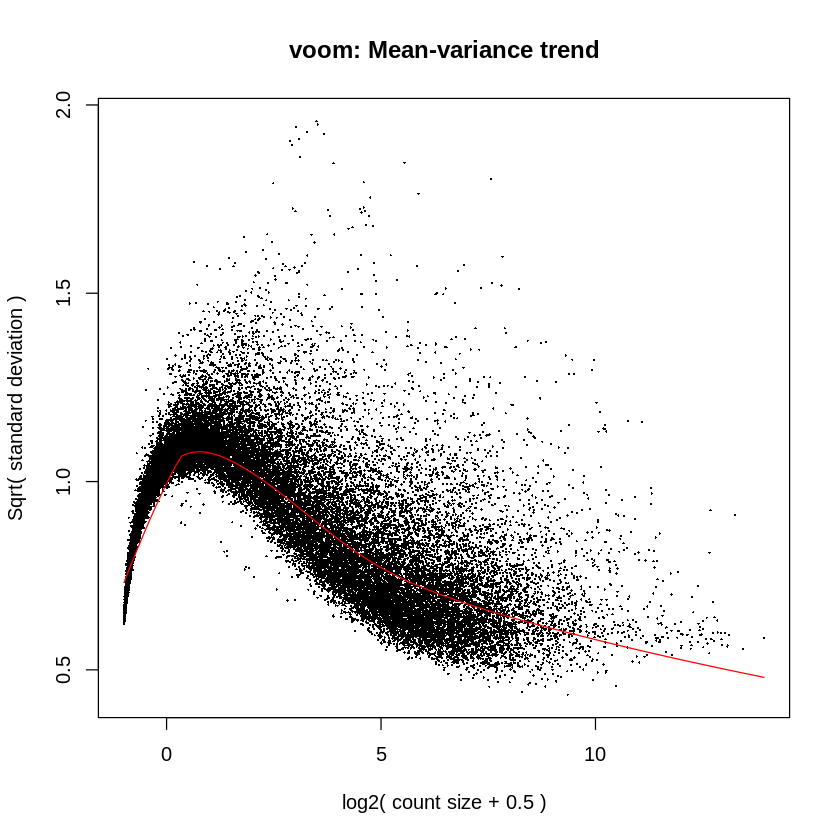

In [ ]:
levels(tissue_list_m_f)
actual_tissue_list_m_f = levels(tissue_list_m_f)
tissue_of_interest = actual_tissue_list_m_f[2]
tissue_of_interest
length(actual_tissue_list_m_f)
length(tissue_list_m_f)

dim(ijc_m_f)
dim(sjc_m_f)
dim(metadata_m_f)
dim(fromGTFnoChrY)

print_exploratory_plots (tissue_of_interest, fromGTFnoChrY, tissue_list_m_f, ijc_m_f, sjc_m_f, metadata_m_f )


[1] 42611  7433

[1] 42611  7433

[1] 7433   79

[1] 7433

ERROR: Error in fit$coefficients[, coef]: subscript out of bounds


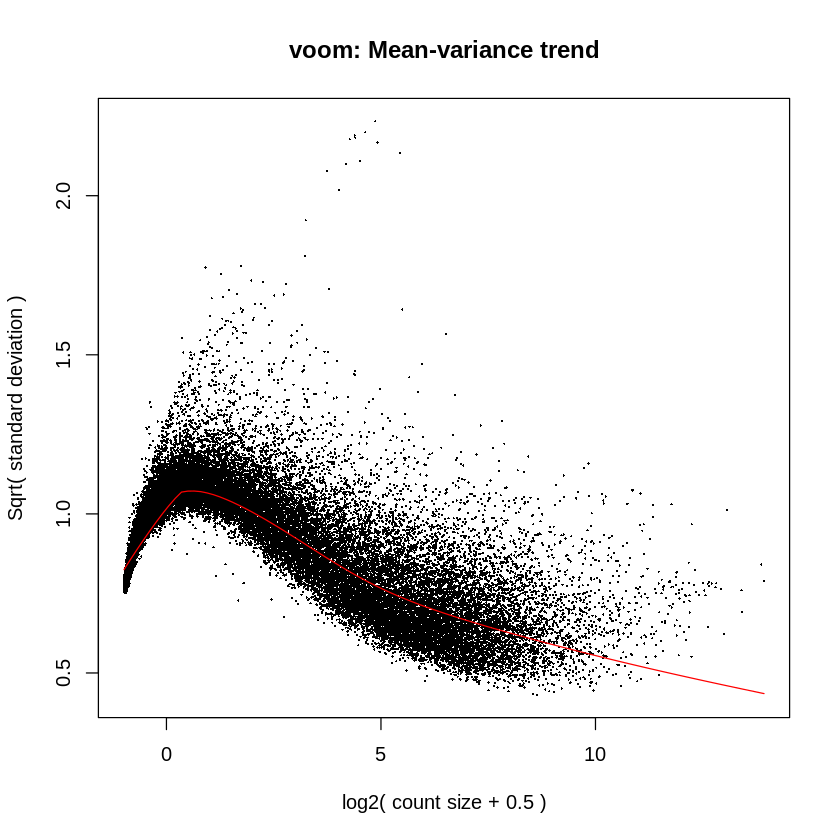

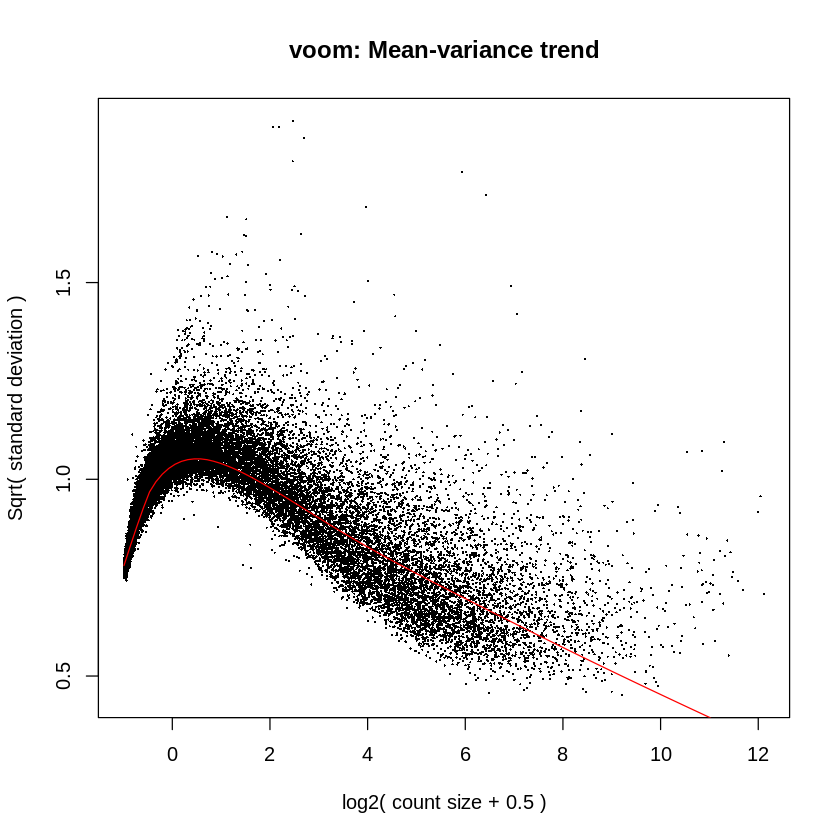

In [59]:
ijc_m_f_modified         = ijc_m_f[          ,keep==TRUE]
sjc_m_f_modified         = sjc_m_f         [          ,keep==TRUE]
metadata_m_f_modified    = metadata_m_f    [keep==TRUE,          ]
tissue_list_m_f_modified = tissue_list_m_f [keep==TRUE]

dim(ijc_m_f_modified)
dim(sjc_m_f_modified)
dim(metadata_m_f_modified)
length(tissue_list_m_f_modified)
tissue_list_m_f_modified = factor(tissue_list_m_f_modified)

lapply(X                  = levels(tissue_list_m_f_modified), 
       FUN                = print_exploratory_plots,
       tissue_list        = tissue_list_m_f_modified,
       ijc                = ijc_m_f_modified, 
       sjc                = sjc_m_f_modified, 
       metadata           = metadata_m_f_modified)

.

## Metadata

For replicability and reproducibility purposes, we also print the following metadata:

1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

### 1. Checksums with the sha256 algorithm

In [82]:
rm (notebookid)
notebookid   = "AllTissueJunctionAnalysis"
notebookid

message("Generating sha256 checksums of the artefacts in the `..data/` directory .. ")
system(paste0("cd ../data && find . -type f -exec sha256sum {} \\;  >  ../metadata/", notebookid, "_sha256sums.txt"), intern = TRUE)
message("Done!\n")

paste0("../metadata/", notebookid, "_sha256sums.txt")

data.table::fread(paste0("../metadata/", notebookid, "_sha256sums.txt"), header = FALSE, col.names = c("sha256sum", "file"))

[1] "AllTissueJunctionAnalysis"

Generating sha256 checksums of the artefacts in the `..data/` directory .. 


character(0)

Done!



[1] "../metadata/AllTissueJunctionAnalysis_sha256sums.txt"

sha256sum,file
<chr>,<chr>
f507001719240ee4bc2a21fa03596fc266690e0f87cd217a772e654067328318,./artery_tibial_DGE_sex_as_events_refined.csv
9e39afe405c59cea8532f404a400b1e5ed41984803bdc400a56a6fa6fc522a89,./artery_tibial_sex_gene_set.txt
d03c22e998eae9c96ab6e07340266fdff0d8f4f896fe7bd62ab80bb5aa7857f1,./BreastMammaryTissue_DGE_ijc_sex.csv
e18bd5ec240dd57f81d096583953da8808c0d7be70548a484a10a9aaab1ae089,./artery_tibial_sjc_sex_universe.txt
2ff06faca7d475089b18e7b0aa2ed8e9d1f4d71b0e7b7783bb82570a41d29798,./BreastMammaryTissue_sex_as_events_universe.txt
087e09232bfa84feeb1342004ee1e10c4881a901cb21729f1b14e80e158d24ae,./bladder_DGE_sjc_sex_refined.csv
8f07440d0159f27effabb06ddb8ec1caae8a2202145e3ce66755ca35f5749d36,./bladder_sex_gene_set.txt
5f90dad03fc9b792ec434aae8dde3d4ebdd5ff6c8a799912f874bf92569c2c5d,./BreastMammaryTissue_DGE_sjc_sex.csv
bb85d65d1b20c87f05aebee4ded28d4f6e3829528388607f90c89a980b269d49,./bladder_DGE_ijc_sex.csv


### 2. Libraries metadata

In [47]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", notebookid, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", notebookid ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]

Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..
Done!

Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..
Done!



 setting  value                       
 version  R version 3.6.1 (2019-07-05)
 os       Ubuntu 18.04.3 LTS          
 system   x86_64, linux-gnu           
 ui       X11                         
 language en_US.UTF-8                 
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2020-05-14                  

,package,ondiskversion,loadedversion,path,loadedpath,attached,is_base,date,source,md5ok,library
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<fct>
Biobase,Biobase,2.46.0,2.46.0,/opt/conda/lib/R/library/Biobase,/opt/conda/lib/R/library/Biobase,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
BiocGenerics,BiocGenerics,0.32.0,0.32.0,/opt/conda/lib/R/library/BiocGenerics,/opt/conda/lib/R/library/BiocGenerics,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
edgeR,edgeR,3.28.1,3.28.1,/opt/conda/lib/R/library/edgeR,/opt/conda/lib/R/library/edgeR,TRUE,FALSE,2020-02-26,Bioconductor,NA,/opt/conda/lib/R/library
limma,limma,3.42.2,3.42.2,/opt/conda/lib/R/library/limma,/opt/conda/lib/R/library/limma,TRUE,FALSE,2020-02-03,Bioconductor,NA,/opt/conda/lib/R/library
multtest,multtest,2.42.0,2.42.0,/opt/conda/lib/R/library/multtest,/opt/conda/lib/R/library/multtest,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
piggyback,piggyback,0.0.10.99,0.0.10.99,/opt/conda/lib/R/library/piggyback,/opt/conda/lib/R/library/piggyback,TRUE,FALSE,2020-05-12,Github (ropensci/piggyback@87f71e8),NA,/opt/conda/lib/R/library
R.methodsS3,R.methodsS3,1.8.0,1.8.0,/opt/conda/lib/R/library/R.methodsS3,/opt/conda/lib/R/library/R.methodsS3,TRUE,FALSE,2020-02-14,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
R.oo,R.oo,1.23.0,1.23.0,/opt/conda/lib/R/library/R.oo,/opt/conda/lib/R/library/R.oo,TRUE,FALSE,2019-11-03,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
R.utils,R.utils,2.9.2,2.9.2,/opt/conda/lib/R/library/R.utils,/opt/conda/lib/R/library/R.utils,TRUE,FALSE,2019-12-08,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
